# Dropout


### **Prerequisites**
* Regularization

***What will we cover in this notebook?***

* Explaining dropout mathematically and intuitively in neural networks
* Implementation in PyTorch
* Showing the difference between non-dropout and dropout models
* Reviewing some key points
-----

### 1. What is Dropout?


**A brief introduction**

A common problem in machine learning is how to increase our model's performance on unseen data. We want to reduce the test error. To achieve this goal, we apply some regularization strategies. Regularization is defined as "any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error". We'll focus on dropout which is one of those strategies !

We basically remove (drop out) some neurons in our original network with some probability. You can assume that we shut down some parts of the neural network during every training example and get different models for each one.

We don't drop out any of neurons during testing. Because we don't want our output to be a random value. In theory, one thing we could do is drop out some neurons in testing part then take the average of each model. But it will be computationally inefficient!


![drop_imp](images/drop_impl.png)

**What is the idea behind 'Dropout'?**

The basic idea of the dropout in neural networks is to prevent overfitting. Sometimes, one part of the networks has large weights and it ends up dominating all the training while the other part of the network doesn't get trained well. We simply turns off some nodes and say, don't pass through here. With this process, we give chance other weak nodes to train as well as the other powerfull ones.

We apply this process by giving the algorithm a parameter. This parameter is the probability that each node gets dropped at a particular epoch.

![drop.gif](images/drop.gif)

*https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a*

### 2. Similarity between dropout and ensembles methods


Bagging (short for bootstrap aggregating) is a technique for reducing generalization error by combining several models. The idea is to train several different models separately, then have all of the models vote on the
output for test examples. This is an example of a general strategy in machine learning called model averaging. 

Techniques employing this strategy are known as ensemble methods.
The reason that model averaging works is that different models will usually
not make all the same errors on the test set.

Dropout can be thought of as a method of making bagging practical for ensembles
of very many large neural networks.

Dropout training is not quite the same as bagging training. 

* In the case of bagging, the models are all independent. 

* In the case of dropout, the models share parameters, with each model inheriting a different subset of parameters from the parent neural network. This parameter sharing makes it possible to represent an exponential number of models with a tractable amount of memory.

* In the case of bagging, each model is trained to convergence on its respective training set. 
* In the case of dropout, typically most models are not explicitly trained at all—usually, the model is large enough that it would be infeasible to sample all possible subnetworks within the lifetime of the universe.

Beyond these differences, dropout follows the bagging algorithm. For
example, the training set encountered by each sub-network is indeed a subset of
the original training set sampled with replacement.

![ensemble](images/ensemble.png)

### 3. Implementation in PyTorch on a basic neural network 

In this section, we'll explain how we apply dropout in theory and in PyTorch together.

We said that, we set a probability of eliminating a node in the network during training. We do this by creating a mask for each layer. This mask is a binary vector which is 

In [2]:
import torch
import torch.nn as nn

def dropout_layer(X, p):
    assert 0 <= p <= 1
    # In this case, all elements are dropped out
    if p == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if p == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > p).float()
    return mask * X / (1.0 - p)

To try the implementation, run the cell below:

In [3]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('Our input vector X:\n',X)
print('If we set probability to 0 and keep every node in the network:\n', dropout_layer(X, 0.))
print('If we set probability to 0.5 and make half of the nodes "0":\n', dropout_layer(X, 0.5))
print('If we set probability to 1 and drop out every node:\n', dropout_layer(X, 1.))

Our input vector X:
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
If we set probability to 0 and keep every node in the network:
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
If we set probability to 0.5 and make half of the nodes "0":
 tensor([[ 0.,  0.,  4.,  6.,  0.,  0., 12.,  0.],
        [ 0., 18., 20.,  0.,  0., 26.,  0., 30.]])
If we set probability to 1 and drop out every node:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


Now, We'll do an implementation with MNIST dataset which is a very popular data and contains 77.000 handwritten digits. Every data points has 28x28 grayscale image and a label (the digit) from 0 to 9. We'll cover non-dropout and dropout models together. Let's do it!
* Load and prepare the dataset

In [4]:
from torchvision import datasets, transforms
import sys
sys.path.append('..')
from utils import get_dataloaders


batch_size = 128

train_loader, val_loader, test_loader = get_dataloaders(batch_size=batch_size)

* It's time to create dropout model !

In [17]:
import torch.nn.functional as F


class NeuralNetworkClass(torch.nn.Module):
    def __init__(self): # initialiser
        super().__init__() # initialise the parent class
        self.layer1 = torch.nn.Linear(784, 1024) # create our first linear layer
        self.layer2 = torch.nn.Linear(1024, 256) # create our second linear layer
        self.layer3 = torch.nn.Linear(256, 10) # create our third linear layer
        
    def forward(self, x): # define the forward pass
        x = x.view(-1, 784) # flatten out our image features into vectors
        x = self.layer1(x) # pass through the first linear layer
        x = F.relu(x) # apply activation function
        x = self.layer2(x) # pass through the second linear layer
        x = F.relu(x) # apply activation function
        x = self.layer3(x) # pass through the third linear layer
        x = F.softmax(x) # apply activation function
        return x # return output



# This is our dropout implementation !
class NeuralNetworkClassDropout(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(784, 1024) # create our first linear layer
        self.layer2 = torch.nn.Linear(1024, 256) # create our second linear layer
        self.layer3 = torch.nn.Linear(256, 10) # create our third linear layer
        self.dropout1 = nn.Dropout(p=0.2)           # first dropout parameter
        self.dropout2 = nn.Dropout(p=0.5)          # second dropout parameter

        
    def forward(self, x):
        x = x.view(-1, 784)     # flatten out our image features into vectors
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout1(x)    # apply first dropout after the first layer
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout2(x)    # apply second dropout after the second layer
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x


In [18]:
learning_rate = 0.001
myNeuralNetwork = NeuralNetworkClass()
myNeuralNetworkDropout = NeuralNetworkClassDropout()

# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss()             # callable class that compares our predictions to our labels and returns our loss

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer_nond = SummaryWriter(log_dir="runs/nondropout")          # we will use this to show our models performance on a graph
writer_d = SummaryWriter(log_dir="runs/dropout")

* Training part:

We assign "p" to represent the probability of a neuron, in the hidden layer, being excluded from the network; this probability value is usually equal to 0.5. We do the same process for the input layer whose probability value is usually lower than 0.5 (e.g. 0.2). Remember, we delete the connections going into, and out of, the neuron when we drop it.

Non-Dropout Model's Loss
Epoch: 1 	Training Loss: 204.9869009686248 	Validation Loss: 193.9748504976683
Epoch: 2 	Training Loss: 194.29549376251143 	Validation Loss: 191.26869778693478
Epoch: 3 	Training Loss: 192.70798980732403 	Validation Loss: 189.93471570558185
Epoch: 4 	Training Loss: 191.88436103293964 	Validation Loss: 189.57923384557796
Epoch: 5 	Training Loss: 191.32276419910323 	Validation Loss: 188.88051286528383
Epoch: 6 	Training Loss: 190.69821810905282 	Validation Loss: 188.4473654831512
Epoch: 7 	Training Loss: 190.50860089353284 	Validation Loss: 188.23027825657326
Epoch: 8 	Training Loss: 190.03801757539324 	Validation Loss: 187.99083637285835
Epoch: 9 	Training Loss: 189.86808993932232 	Validation Loss: 187.82364507264728
Epoch: 10 	Training Loss: 189.624215104086 	Validation Loss: 187.65174976783462


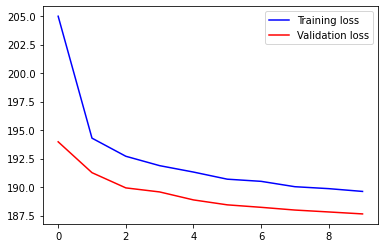

Dropout Model's Loss
Epoch: 1 	Training Loss: 206.79480313644996 	Validation Loss: 194.28621666340888
Epoch: 2 	Training Loss: 194.62347679430871 	Validation Loss: 191.51693138895155
Epoch: 3 	Training Loss: 192.63905684722354 	Validation Loss: 190.07541299168068
Epoch: 4 	Training Loss: 191.79880947591093 	Validation Loss: 189.76985395407374
Epoch: 5 	Training Loss: 191.15274794205376 	Validation Loss: 188.8528586761861
Epoch: 6 	Training Loss: 190.67964348951568 	Validation Loss: 188.53111015995847
Epoch: 7 	Training Loss: 190.33451114469173 	Validation Loss: 188.4248839028274
Epoch: 8 	Training Loss: 190.06319793837758 	Validation Loss: 187.91865054263343
Epoch: 9 	Training Loss: 189.92674022196505 	Validation Loss: 187.53442938116532
Epoch: 10 	Training Loss: 189.71777881807682 	Validation Loss: 187.59368976158433


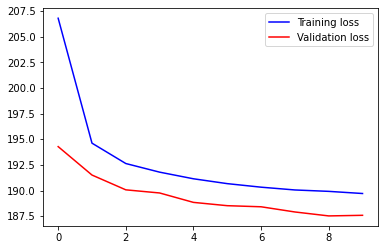

In [19]:
import matplotlib.pyplot as plt

# TRAINING LOOP
def train(model, epochs, writer, verbose=True):
    model.train()                                  # put the model into training mode (more on this later)
    losses_train = []
    losses_val = []
    for epoch in range(epochs):
        running_loss_train = 0.0
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            # CREATE OUR OPTIMISER
            optimiser = torch.optim.Adam(          # what optimiser should we use?
            model.parameters(),                    # what should it optimise?
            lr=learning_rate                       # using what learning rate?
            )
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            running_loss_train += loss.item() * inputs.size(0)

        model.eval()
        running_loss_val = 0.0
        for idx, minibatch in enumerate(val_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            # CREATE OUR OPTIMISER
            optimiser = torch.optim.Adam(          # what optimiser should we use?
            model.parameters(),                    # what should it optimise?
            lr=learning_rate                       # using what learning rate?
            )
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Validation', loss, epoch*len(val_loader) + idx)    # write loss to a graph
            running_loss_val += loss.item() * inputs.size(0)

        epoch_loss_train = running_loss_train / len(train_loader)
        losses_train.append(epoch_loss_train)

        epoch_loss_val = running_loss_val / len(val_loader)
        losses_val.append(epoch_loss_val)

        print('Epoch:', epoch+1, '\tTraining Loss:', epoch_loss_train, '\tValidation Loss:', epoch_loss_val)

    plt.plot(losses_train,'b-', label='Training loss')
    plt.plot(losses_val, 'r-', label='Validation loss')
    plt.legend()
    plt.show()


print("Non-Dropout Model's Loss")
train(myNeuralNetwork, 10, writer=writer_nond)
print("Dropout Model's Loss")           
train(myNeuralNetworkDropout, 10, writer=writer_d)

* Evaluate our two models:

In [20]:
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)              # test DATA not test LOADER
    for inputs, labels in dataloader:                   # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

print("Non-Dropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetwork, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetwork, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetwork, test_loader))

print("\nDropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetworkDropout, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetworkDropout, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetworkDropout, test_loader))


Non-Dropout Model's Evaluation:
Train Accuracy: 97.992
Validation Accuracy: 98.22999999999999
Test Accuracy: 97.28

Dropout Model's Evaluation:
Train Accuracy: 97.892
Validation Accuracy: 98.28
Test Accuracy: 97.35000000000001


### 4. Visualizing the difference between a non-dropout and dropout implemented nn


![train_loss_comp.png](images/train_loss_comp.png)

As we see above, our model's loss curves are converged. They perform very good on training data, but it is poor on test data. So that means, we have an overfitting problem.

We tried a dropout model and saw that test accuracy increased.

* Non-Dropout Model Test Accuracy: 97.28
* Dropout Model Test Accuracy: 97.35000000000001

**What to do while testing?**



### 5. Summary

* Dropout means turning off some neurons in our network with some probability.
* Dropout helps us to prevent overfitting.
* Dropout follows the bagging algorithm. The training set encountered by each sub-network is indeed a subset of the original training set sampled with replacement. This is the similarity between ensemble models and dropout method.
* Dropout is only used during training.


### 6. What to do next?
* Try to change the dropout parameters and see its effect on training loss and accuracy
* Try to combine dropout with other regularization methods and compare model's performances
* What is the ideal dropout probability rate for different layers? How to choose it? Do some research on the internet, check out the papers and articles.